In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import spatial_metrics.helper_functions as hf
import spatial_metrics.spatial_metrics_calcium_binarized_base as sm
import spatial_metrics.bootstrapped_estimation as be
from spatial_metrics.data_processing import ProcessData
from spatial_metrics.data_loader import LoadData



In [5]:
# Initialize loader
loader = LoadData('kinsky')

# See what's available
loader.list_available()
# loader.show_jupyter_tree()

Dataset path resolved: /home/apolo/Documents/github_projects/information_metrics/tutorial/data/kinsky


{'available': {'mouse_1': {'days': [1], 'sessions': [1]},
  'mouse_2': {'days': [2], 'sessions': [1]},
  'mouse_4': {'days': [1], 'sessions': [1]},
  'mouse_3': {'days': [1], 'sessions': [1]}}}

In [9]:

# Load specific dataset
data = loader.load(mouse_id=1, day=1, session=1)
data


{'position': {'x': array([33.31549965, 33.68112613, 33.87063125, ..., 31.16963385,
         30.92036124, 30.71436074], shape=(12341,)),
  'y': array([53.24076999, 53.44182864, 53.44689017, ..., 42.53673027,
         42.20114903, 41.8824232 ], shape=(12341,)),
  'time': array([ 16.3 ,  16.35,  16.4 , ..., 633.2 , 633.25, 633.3 ],
        shape=(12341,))},
 'traces': {'raw': array([[-1.5893332e-03, -2.1475016e-03, -2.3348499e-03, ...,
           7.3202150e-03,  6.1626555e-03,  6.5705916e-03],
         [-5.5961423e-03, -3.9062107e-03, -4.2496477e-03, ...,
          -1.5494933e-03, -3.0333218e-03, -2.4431562e-03],
         [-5.3208605e-03, -3.0862184e-03, -5.0647734e-03, ...,
          -9.8666633e-03, -7.8982897e-03, -8.5074883e-03],
         ...,
         [-7.5973622e-03, -6.5999418e-03, -6.8442142e-03, ...,
           8.8632223e-04,  2.4203248e-03,  2.8515742e-03],
         [ 3.6098133e-04, -7.1392598e-04,  8.5577049e-05, ...,
          -3.3039865e-03, -1.8775027e-03, -1.7858761e-03],
  

In [9]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import spatial_metrics.helper_functions as hf
import spatial_metrics.spatial_metrics_calcium_binarized_base as sm
import spatial_metrics.bootstrapped_estimation as be
from spatial_metrics.data_processing import ProcessData
from spatial_metrics.data_loader import LoadData

%matplotlib widget



ImportError: cannot import name 'LoadData' from 'spatial_metrics.data_loader' (/home/apolo/Documents/github_projects/information_metrics/spatial_metrics/data_loader.py)


'''
If you don't have calcium signal, this part simulates the calcium activity
from a place cell in a 2D enviroment.

You should first set your environment edges. You can think of it as a retangular box in cm.
environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]

Now set the number of place fields (if num_of_fields = 0, then the cell is not a place cell),
their location in the enviroment, and their respective sizes.
'''


In [2]:
# Arguments taken from the paper "Hippocampal Place Fields Maintain a Coherent and
# Flexible Map across Long Timescales"

# Here we will load data from Kinsky et al. paper and use their definitions

import os
from pathlib import Path

# Get the current working directory
current_dir = Path.cwd()
current_dir

project_root = current_dir.parent 
project_root = '/home/apolo/Documents/github_projects/information_metrics'
# data_dir = f"{project_root}/data/Kinsky/Mouse1 - G30/day 1/1 - square/"
# data_dir = f"{project_root}/data/Kinsky/Mouse1 - G30/day 4/1 - square/"
# data_dir = f"{project_root}/data/Kinsky/Mouse2 - G31/day 4/1 - square/"
data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 1/1 - square/"
# data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 4/1 - square/"
# data_dir = f"{project_root}/data/Kinsky/Mouse4 - G48/day 4/1 - square/"
# data_dir = f"{project_root}/data/Kinsky/Mouse4 - G48/day 4/2 - square 90CW/"

os.chdir(data_dir)

import h5py
import mat73
from scipy.io import loadmat

mat_file = 'Pos_align.mat'
mat_dict = loadmat(mat_file,simplify_cells=True)

x_coordinates = mat_dict['x_adj_cm']
y_coordinates = mat_dict['y_adj_cm']
time_vector = mat_dict['time_interp']

raw_trace = mat_dict['RawTrace'] # raw signal
lp_trace = mat_dict['LPtrace'] # filtered signal
dfdt_trace = mat_dict['DFDTtrace'] # diff signal
psabool_trace = mat_dict['PSAbool'] # binarized signal
speed = mat_dict['speed']
sampling_rate = 20 # info taken from their paper
raw_trace.shape

cell = 267
input_signal = psabool_trace[cell,:]
signal_norm = lp_trace[cell,:]
signal_type = 'binarized'

environment_edges = [[5,35],[15,45]]


# Create a dictionary to hold input parameters for further processing
input_dict = dict()

# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)
input_dict['signal_type'] = signal_type  

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
input_dict['min_visits'] = 0  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 0  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
input_dict['speed_smoothing_sigma'] = 0.5  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and spatial information calculation
input_dict['environment_edges'] = environment_edges  # Coordinates defining the edges of the environment (in coordinate units)
input_dict['x_bin_size'] = 1  # Size of x bins (in coordinate units [e.g., cm, pixels])
input_dict['y_bin_size'] = 1  # Size of y bins (in coordinate units [e.g., cm, pixels])
input_dict['map_smoothing_sigma_x'] = 2.5  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
input_dict['map_smoothing_sigma_y'] = 2.5 # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 800  # Number of surrogate distributions to generate

# Set parameters for place fields detection
input_dict['min_num_of_bins'] = 2  # Minimum number of xy-bins required to define a place field

input_dict['field_detection_method'] = 'std_from_field'  # place field detection method (std_from_field or random_fields)
input_dict['percentile_threshold'] = 99  # Percentile threshold for determining place field boundaries when field_detection_method = 'random_fields'
input_dict['detection_threshold'] = 1 # place field detection threshold in std when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_x'] = 2.5  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_y'] = 2.5  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'


signal_data = SignalData(input_signal,x_coordinates,y_coordinates,time_vector)

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(signal_data)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.binarized.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


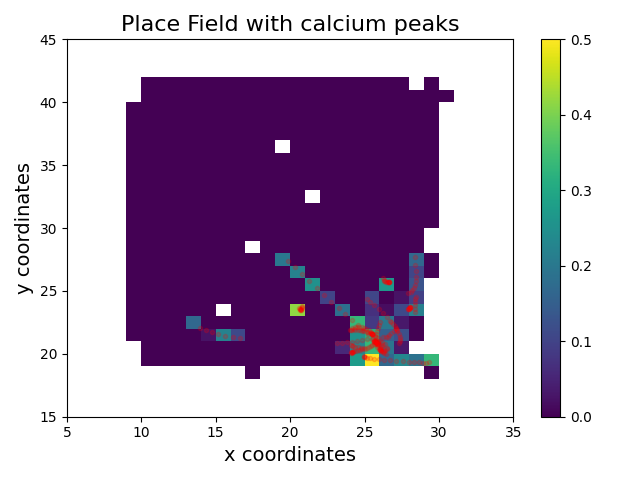

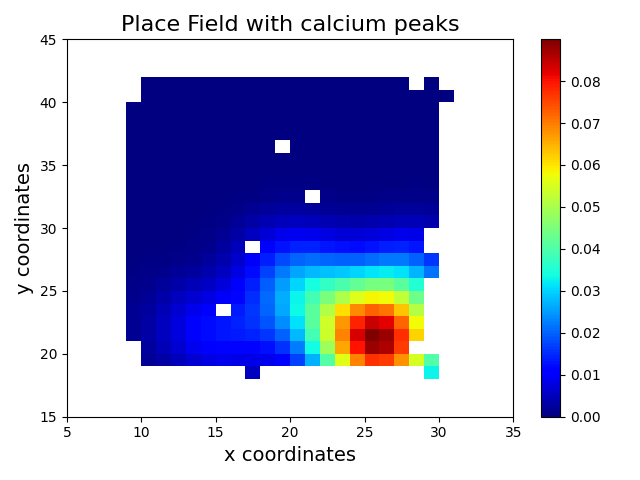

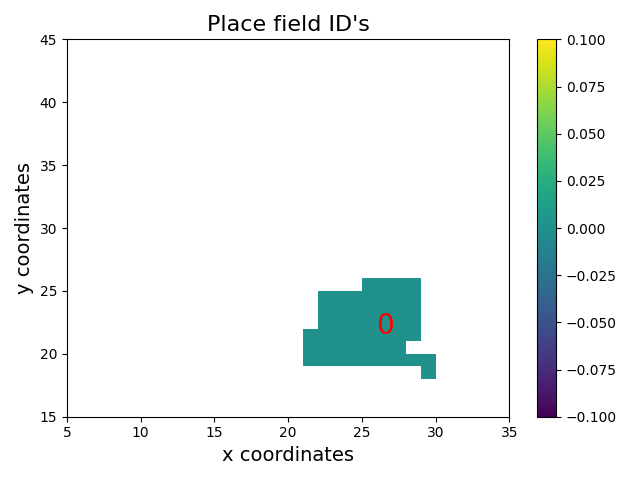

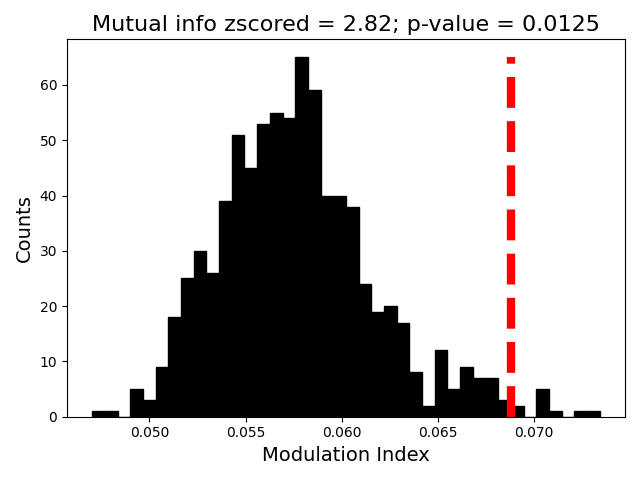

In [7]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
plt.colorbar()
plt.plot(spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_y_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map_smoothed'],edgecolors=None,cmap='jet')

# plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_identity'])
plt.colorbar()

for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()

statistic = be.calculate_p_value(spatial_metrics_output['mutual_info_original'], spatial_metrics_output['mutual_info_shifted'], alternative='greater')

counts,bins = np.histogram(spatial_metrics_output['mutual_info_shifted'],40)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_original'],spatial_metrics_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(spatial_metrics_output['mutual_info_zscored'],statistic.p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [74]:
spatial_information

np.float64(0.06937518903448207)

In [51]:
cell = 267
input_signal = psabool_trace[cell,:]
signal_norm = lp_trace[cell,:]
signal_type = 'Binarized'


In [52]:
x_bin_size = 1
y_bin_size = 1
x_grid, y_grid, x_center_bins, y_center_bins, x_center_bins_repeated, y_center_bins_repeated = hf.get_position_grid(
x_coordinates, y_coordinates, x_bin_size, y_bin_size,
environment_edges=environment_edges)

In [78]:
x_grid.shape

(121,)

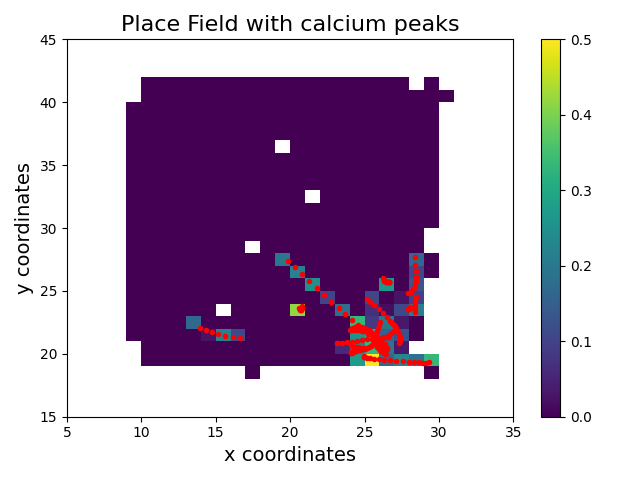

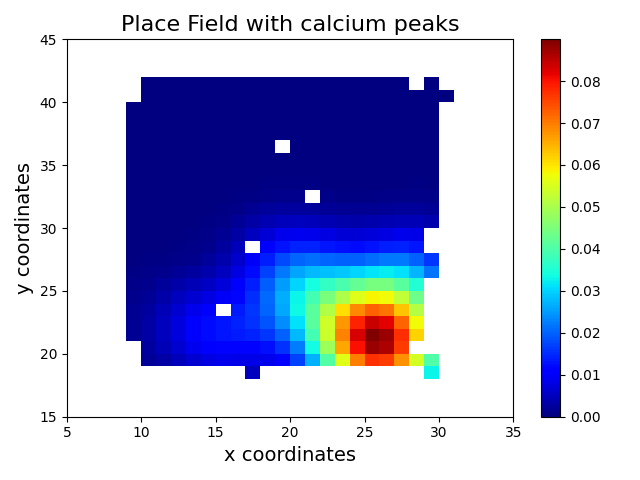

In [27]:

plt.figure()
plt.pcolormesh(x_grid,y_grid,activity_map,edgecolors=None)
plt.plot(x_coordinates[psabool_trace[cell,:] == 1],y_coordinates[psabool_trace[cell,:]==1],'r.')
plt.colorbar()

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



plt.figure()
plt.pcolormesh(x_grid,y_grid,activity_map_smoothed,edgecolors=None,cmap='jet')
# plt.plot(x_coordinates[psabool_trace[cell,:] == 1],y_coordinates[psabool_trace[cell,:]==1],'r.')

plt.colorbar()

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



In [ ]:
# Cells from fig 2C are 49,127,211,267 from
# data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 1/1 - square/"


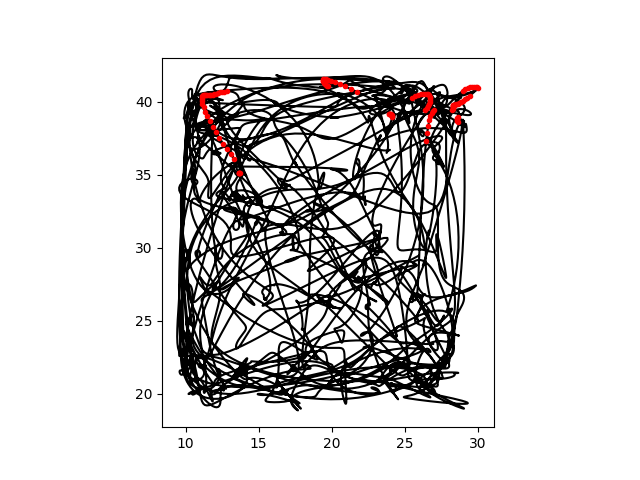

In [47]:
cell = 211

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[psabool_trace[cell,:] == 1],y_coordinates[psabool_trace[cell,:]==1],'r.')
plt.gca().set_aspect('equal')
plt.show()


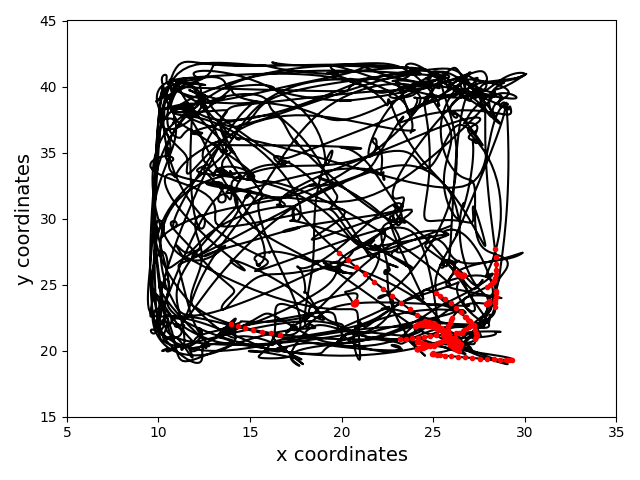

In [6]:
# environment_edges = [[10,50],[35,70]]
environment_edges = [[5,35],[15,45]]
plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[psabool_trace[cell,:] == 1],y_coordinates[psabool_trace[cell,:]==1],'r.')
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



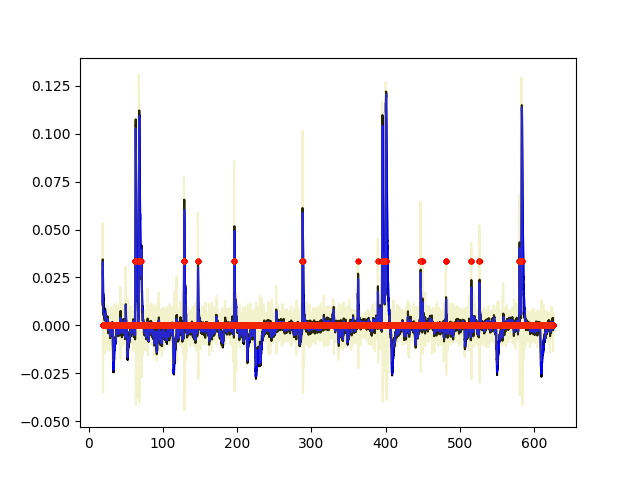

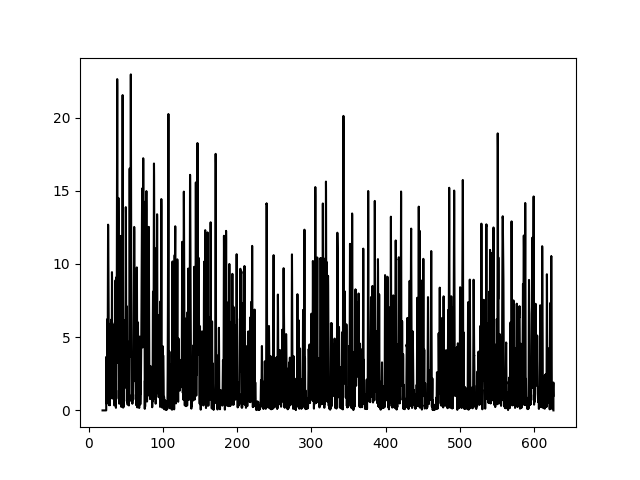

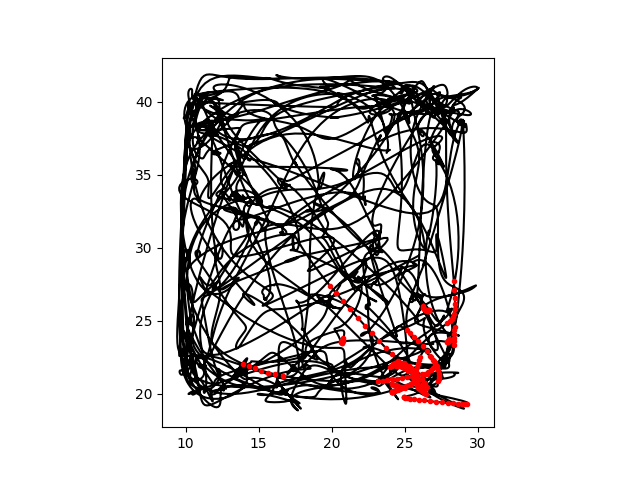

In [6]:
# 49,127,211,267
cell = 267
plt.figure()
plt.plot(time_vector,raw_trace[cell,:],'k')
plt.plot(time_vector,lp_trace[cell,:],'b')
plt.plot(time_vector,psabool_trace[cell,:]/30,'r.')
plt.plot(time_vector,dfdt_trace[cell,:]/100,'y',alpha=0.2)
plt.show()

plt.figure()
plt.plot(time_vector,speed,'k')
plt.show()

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[psabool_trace[cell,:] == 1],y_coordinates[psabool_trace[cell,:]==1],'r.')


plt.gca().set_aspect('equal')
plt.show()


In [58]:
# # Load simulated data:

# output_dict = np.load('simulated_signal.npy',allow_pickle=True).item()
# signal = output_dict['signal']
# time_vector = output_dict['time_vector']
# x_coordinates = output_dict['x_coordinates']
# y_coordinates = output_dict['y_coordinates']
# modulated_spike_times_idx = output_dict['spike_times']
# environment_edges = output_dict['environment_edges']
# sampling_rate = output_dict['sampling_rate']

# signal_norm = hf.min_max_norm(signal)


In [7]:

cell = 267
input_signal = psabool_trace[cell,:]
signal_norm = lp_trace[cell,:]
signal_type = 'Binarized'


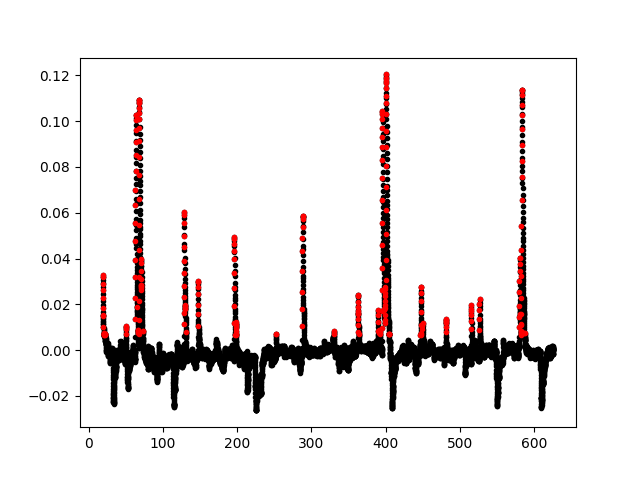

In [11]:
# # play with z_threshold just to decide which one is the best for your data

signal_type = 'Binarized'
sampling_rate = 1 / np.nanmean(np.diff(time_vector))
input_signal = hf.preprocess_signal(signal_norm,sampling_rate,signal_type,z_threshold = 0.5)

plt.figure()
plt.plot(time_vector,signal_norm,'k.')
plt.plot(time_vector[input_signal==1],signal_norm[input_signal==1],'r.')
# plt.plot(time_vector[input_signal==1],signal_norm[input_signal==1],'r.')
# plt.plot(time_vector,input_signal,'r.')
plt.show()


In [10]:
environment_edges = [[5,35],[15,45]]

# Calculate the video sampling rate as the reciprocal of the average time difference between consecutive timestamps.
# This is an approximation for cameras with varying frame rates.
signal_type = 'Binarized'
sampling_rate = 1 / np.nanmean(np.diff(time_vector))

# Create a dictionary to hold input parameters for further processing
input_dict = dict()

# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)

# Set parameters related to the signal and environment
input_dict['sampling_rate'] = sampling_rate  # Sampling rate in points per second
input_dict['environment_edges'] = environment_edges  # Coordinates defining the edges of the environment (in coordinate units)

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
input_dict['min_visits'] = 1  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 1  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
input_dict['speed_smoothing_sigma'] = 1  # Std of the gaussian smooth. Units should be in the time vector df

# Set parameters for plotting (this will not affect spatial information calculation)
input_dict['map_smoothing_sigma_x'] = 2.5  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
input_dict['map_smoothing_sigma_y'] = 2.5  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps



# Set parameters for calculating spatial information
input_dict['x_bin_size'] = 1  # Size of x bins (in coordinate units [e.g., cm, pixels])
input_dict['y_bin_size'] = 1  # Size of y bins (in coordinate units [e.g., cm, pixels])

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 800  # Number of surrogate distributions to generate


# Set parameters for place fields detection
input_dict['min_num_of_bins'] = 2  # Minimum number of xy-bins required to define a place field

input_dict['field_detection_method'] = 'std_from_field'  # place field detection method (std_from_field or random_fields)
input_dict['percentile_threshold'] = 95  # Percentile threshold for determining place field boundaries when field_detection_method = 'random_fields'
input_dict['detection_threshold'] = 1 # place field detection threshold in std when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_x'] = 2  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_sigma_y'] = 2  # Gaussian 2D std of the smoothing area in coordinate units for detecting place fields when field_detection_method = 'std_from_field'

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(input_signal,time_vector,x_coordinates,y_coordinates)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

TypeError: field_coordinates_using_threshold() got an unexpected keyword argument 'detection_smoothing_sigma_x'. Did you mean 'detection_smoothing_sigma'?

In [ ]:
# make sure the sigma points are correct. They should reflect the unit from which it`s called
# in the case of speed, it should be time_vector

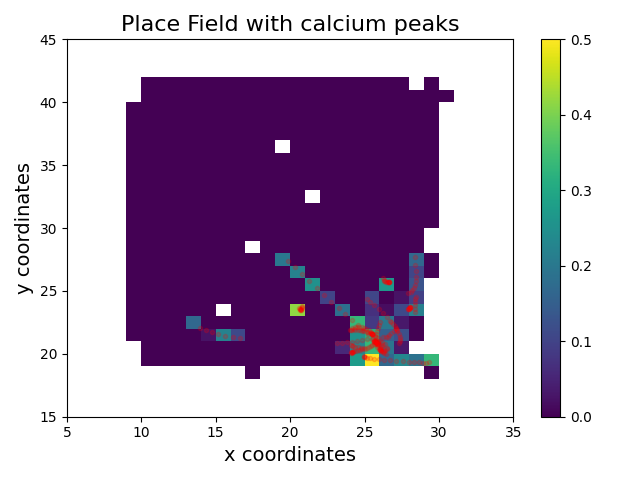

In [3]:

plt.figure()
# plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors='red')
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
plt.colorbar()
plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



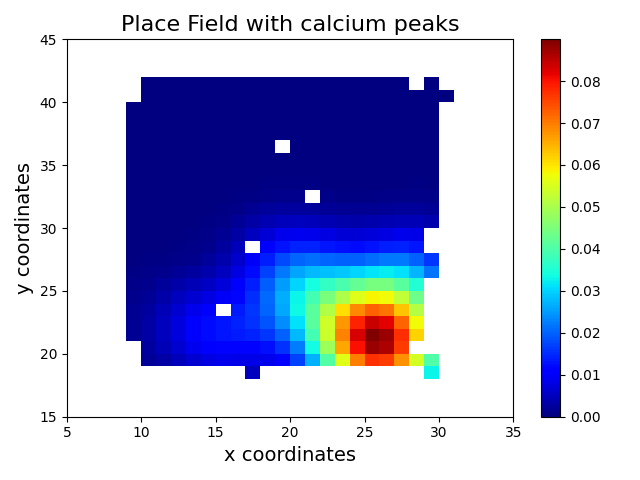

In [15]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map_smoothed'],edgecolors=None,cmap='jet')

# plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



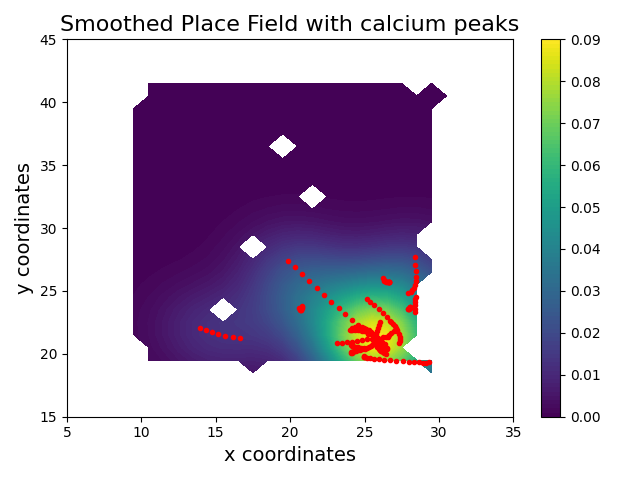

In [14]:

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100,cmap='viridis')
plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



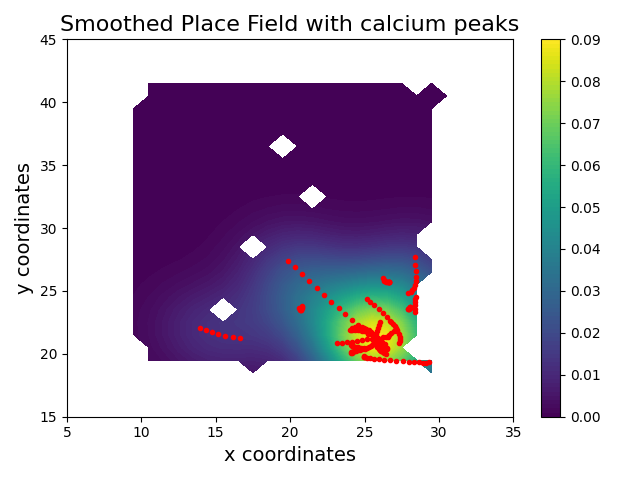

In [8]:


plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100,cmap='viridis')
plt.plot(spatial_metrics_output['x_peaks_location'],spatial_metrics_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



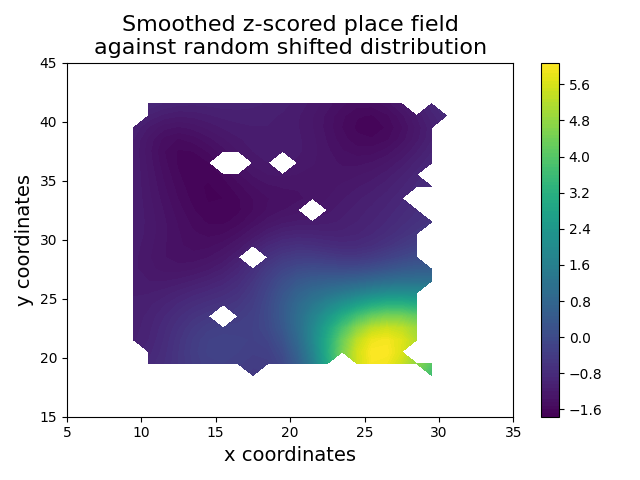

In [5]:

mean_activity_map_shifted = np.nanmean(spatial_metrics_output['activity_map_smoothed_shifted'],0)
std_activity_map_shifted = np.nanstd(spatial_metrics_output['activity_map_smoothed_shifted'],0)
activity_map_smoothed = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_smoothed_zscored = (activity_map_smoothed - mean_activity_map_shifted)/std_activity_map_shifted

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],activity_map_smoothed_zscored,100)
plt.colorbar()
plt.title('Smoothed z-scored place field\nagainst random shifted distribution',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


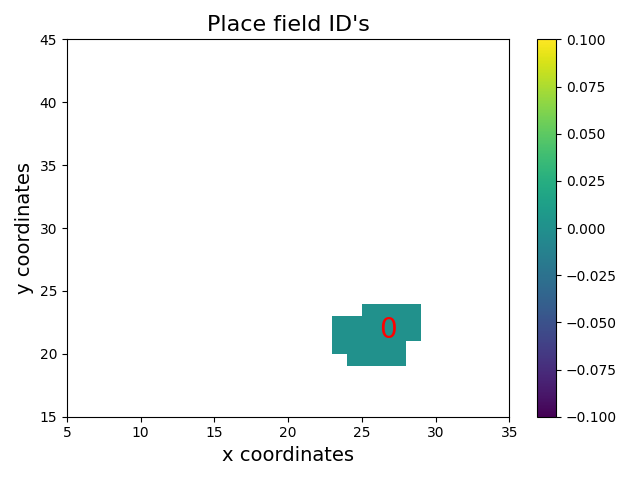

In [6]:

place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_identity'])
plt.colorbar()

for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



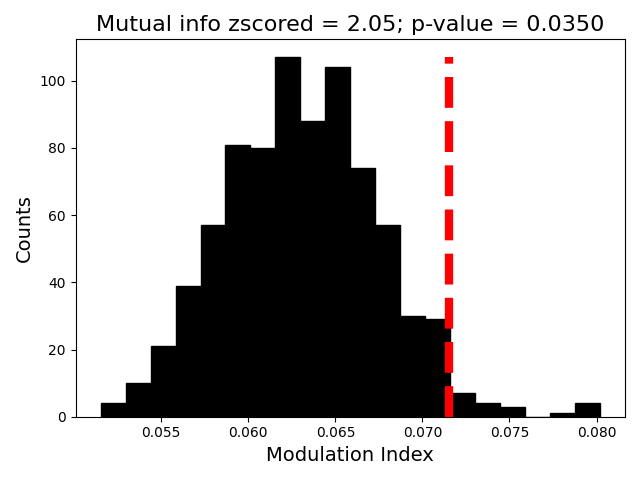

In [7]:
statistic = be.calculate_p_value(spatial_metrics_output['mutual_info_original'], spatial_metrics_output['mutual_info_shifted'], alternative='two-sided')

counts,bins = np.histogram(spatial_metrics_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_original'],spatial_metrics_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(spatial_metrics_output['mutual_info_zscored'],statistic.p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
# Place field extension relative to the whole enviroment
spatial_metrics_output['place_cell_extension_absolute']


array([0.02777778])

In [10]:
# Place field extension relative to enviroment occupancy
spatial_metrics_output['place_cell_extension_relative']


array([0.05458515])

In [12]:
spatial_metrics_output.keys()


dict_keys(['activity_map', 'activity_map_smoothed', 'activity_map_shifted', 'activity_map_smoothed_shifted', 'timespent_map', 'visits_map', 'speed_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'x_peaks_location', 'y_peaks_location', 'activity_map_identity', 'num_of_fields', 'fields_x_max', 'fields_y_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shifted', 'mutual_info_zscored', 'mutual_info_centered', 'input_parameters'])

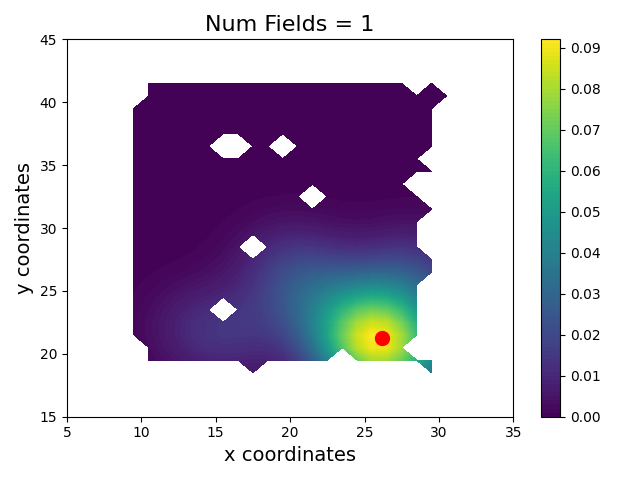

In [9]:
activity_map_x_center_coord = spatial_metrics_output['fields_x_max']
activity_map_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.contourf(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'],100)
# plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_smoothed'])
plt.colorbar()
plt.plot(activity_map_x_center_coord,activity_map_y_center_coord,'r.',markersize=20)

plt.title('Num Fields = {0}'.format(spatial_metrics_output['num_of_fields']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


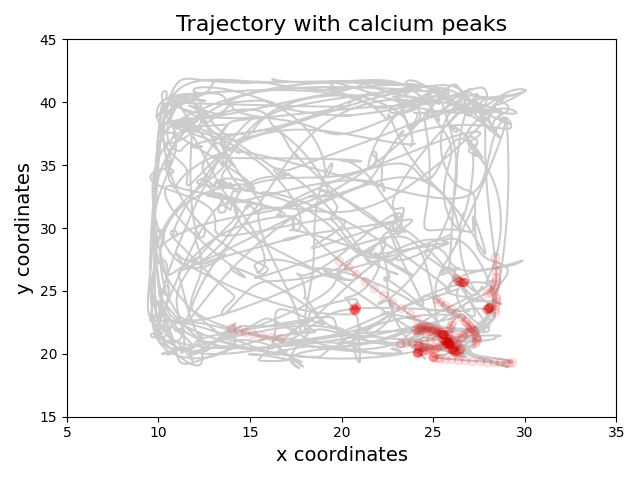

In [41]:

x_peaks_location = spatial_metrics_output['x_peaks_location']
y_peaks_location = spatial_metrics_output['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


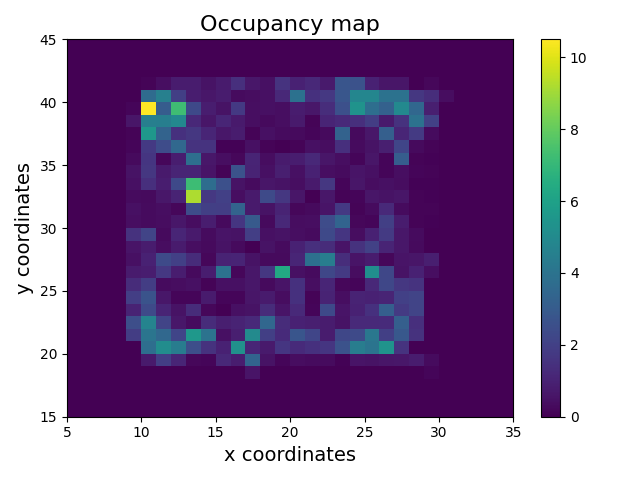

In [42]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['timespent_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


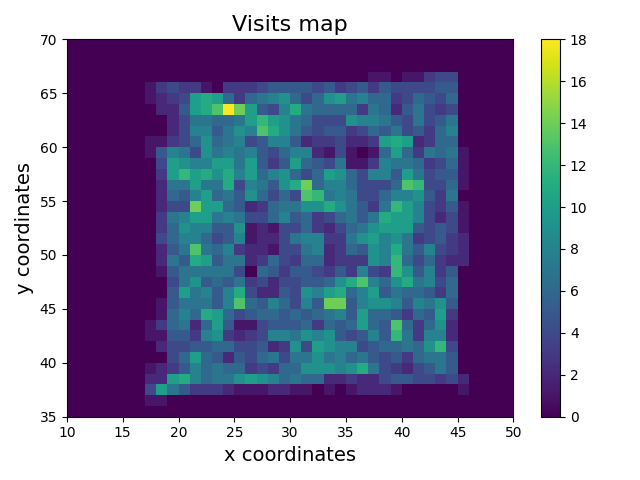

In [107]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


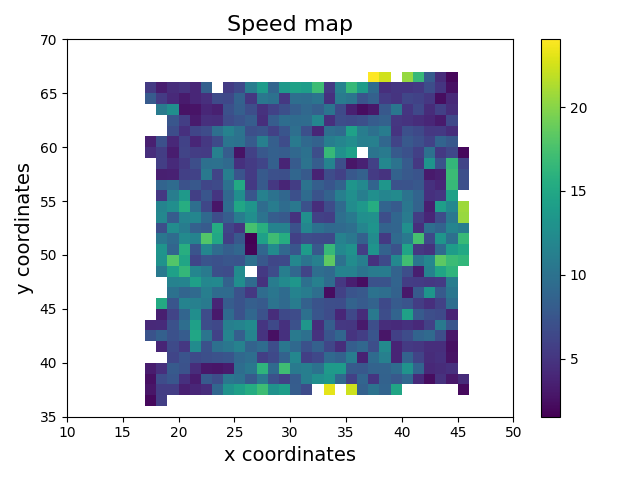

In [108]:


plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['speed_map'])
plt.colorbar()
plt.title('Speed map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()
